In [31]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
def simulate_dispatch(states_info, 
                      start_date="2025-07-01", 
                      hours=24, 
                      apply_solar_tariff=True,yearly = False):
    """
    Simulates power dispatch for given states using PyPSA.

    Parameters:
    - states_info: dict of the form
        {
          "Karnataka": {"Solar": 9300, "Coal": 10000, "demand": 5000},
          "Maharashtra": {"Solar": 4800, "Coal": 15000, "demand": 6000}
        }
    - start_date: string (start of simulation)
    - hours: int (number of hours to simulate)
    - apply_solar_tariff: bool (whether 25% solar transmission cost is applied)
    """
    n = pypsa.Network()
    if not yearly:
        n.set_snapshots(pd.date_range(start=start_date, periods=hours, freq="h"))
    else:
        n.set_snapshots(pd.date_range(start=start_date, periods=365, freq="D"))

    # Marginal costs (₹/MWh)
    marginal_costs = {"Solar": 0, "Coal": 3000}

    # Solar transmission tariff (₹/MWh)
    solar_transmission_cost = 400 if apply_solar_tariff else 0

    # Constant solar capacity factor
    solar_cf = pd.Series(0.18, index=n.snapshots)

    

    for state, info in states_info.items():
        # Add buses
        n.add("Bus", f"{state}")
        n.add("Bus", f"{state} Solar Bus")
        n.add("Bus", f"{state} Coal Bus")

        # Add generators
        for tech in ["Solar", "Coal"]:
            tech_bus = f"{state} {tech} Bus"
            cf = solar_cf if tech == "Solar" else 1.0
            n.add("Generator",
                  name=f"{state} {tech}",
                  bus=tech_bus,
                  p_nom=info[tech],
                  marginal_cost=marginal_costs[tech],
                  p_nom_extendable=False,
                  p_max_pu=cf)

            # Internal link from tech bus to main bus
            n.add("Link",
                  name=f"{state} {tech} merge",
                  bus0=tech_bus,
                  bus1=state,
                  p_nom=info[tech],
                  marginal_cost=0)

        # Add demand
        demand_series = pd.Series(info["demand"], index=n.snapshots)
        n.add("Load", name=f"{state} load", bus=state, p_set=demand_series)

    # Add transmission links between states (solar and coal)
    state_list = list(states_info.keys())
    if len(state_list) == 2:
        s1, s2 = state_list[0], state_list[1]

        # Solar flow (tariffed)
        n.add("Link",
              name=f"{s1[:2]}-{s2[:2]} solar link",
              bus0=f"{s1} Solar Bus",
              bus1=f"{s2}",
              p_nom=2000,
              p_min_pu=-1,
              marginal_cost=solar_transmission_cost)

        # Coal flow (free)
        n.add("Link",
              name=f"{s1[:2]}-{s2[:2]} coal link",
              bus0=f"{s1} Coal Bus",
              bus1=f"{s2}",
              p_nom=2000,
              p_min_pu=-1,
              marginal_cost=0)

    # Solve the optimization
    n.optimize(solver_name="highs")

    # Output results
    print("\n=== Generator Dispatch (First 5 Hours) ===")
    print(n.generators_t.p.head())

    print("\n=== Transmission Flows (First 5 Hours) ===")
    for link in n.links.index:
        if "link" in link:
            print(link)
    print(n.links_t.p0.filter(like="link").head())

    print(f"\n=== Total System Cost (₹) ===\n{n.objective:.2f}")

    return n


In [33]:
def plot(n):
    dispatch = n.generators_t.p
    dispatch.columns.name = "Generator"

    # Create grouped categories: state and tech
    dispatch_grouped = dispatch.copy()
    dispatch_grouped.columns = dispatch.columns.str.extract(r"(\w+)\s+(Solar|Coal)").agg('_'.join, axis=1)

    # Sum by technology type
    dispatch_sum = dispatch_grouped.groupby(axis=1, level=0).sum()

    # Plot
    dispatch_sum.plot.area(figsize=(12, 6), colormap="Set2")
    num_days = n.snapshots.normalize().nunique()
    plt.title("Total Generator Dispatch (MW) Over the time period",)
    plt.xlabel("Date")
    plt.ylabel("Power Output (MW)")
    plt.legend(title="Source")
    plt.tight_layout()
    plt.show()


### Analysis of hourly coal and solar power dispatch between Maharashtra and Karnataka with solar transmission subsidy

Index(['Karnataka Solar merge', 'Karnataka Coal merge',
       'Maharashtra Solar merge', 'Maharashtra Coal merge', 'Ka-Ma solar link',
       'Ka-Ma coal link'],
      dtype='object', name='Link')
Index(['Karnataka', 'Karnataka Solar Bus', 'Karnataka Coal Bus', 'Maharashtra',
       'Maharashtra Solar Bus', 'Maharashtra Coal Bus'],
      dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.02s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 240 primals, 624 duals
Objective: 6.09e+08
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.
C:\Users\Swapnil Paranjape\AppData\Local\Temp\ipykernel_6448\3780353702.py:10: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)`


=== Generator Dispatch (First 5 Hours) ===
Generator            Karnataka Solar  Karnataka Coal  Maharashtra Solar  \
snapshot                                                                  
2025-07-01 00:00:00           1674.0          7000.0              864.0   
2025-07-01 01:00:00           1674.0          7000.0              864.0   
2025-07-01 02:00:00           1674.0          7000.0              864.0   
2025-07-01 03:00:00           1674.0          7000.0              864.0   
2025-07-01 04:00:00           1674.0          7000.0              864.0   

Generator            Maharashtra Coal  
snapshot                               
2025-07-01 00:00:00            1462.0  
2025-07-01 01:00:00            1462.0  
2025-07-01 02:00:00            1462.0  
2025-07-01 03:00:00            1462.0  
2025-07-01 04:00:00            1462.0  

=== Transmission Flows (First 5 Hours) ===
Ka-Ma solar link
Ka-Ma coal link
Link                 Ka-Ma solar link  Ka-Ma coal link
snapshot          

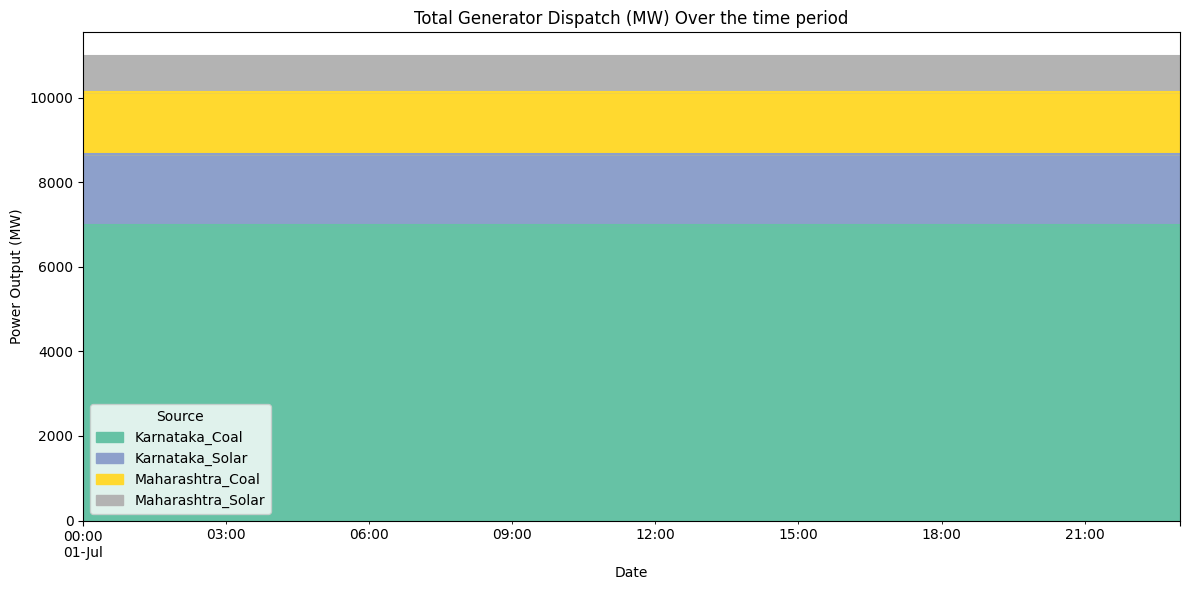

In [34]:
states_info = {
    "Karnataka": {"Solar": 9300, "Coal": 10000, "demand": 5000},
    "Maharashtra": {"Solar": 4800, "Coal": 15000, "demand": 6000}
}

n = simulate_dispatch(states_info, hours=24, apply_solar_tariff=False)
plot(n)


### Analysis of hourly coal and solar power dispatch between Maharahstra and Karnataka without solar transmission subsidy

In [35]:
states_info = {
    "Karnataka": {"Solar": 9300, "Coal": 10000, "demand": 5000},
    "Maharashtra": {"Solar": 4800, "Coal": 15000, "demand": 6000}
}

simulate_dispatch(states_info, hours=24, apply_solar_tariff=True)

Index(['Karnataka Solar merge', 'Karnataka Coal merge',
       'Maharashtra Solar merge', 'Maharashtra Coal merge', 'Ka-Ma solar link',
       'Ka-Ma coal link'],
      dtype='object', name='Link')
Index(['Karnataka', 'Karnataka Solar Bus', 'Karnataka Coal Bus', 'Maharashtra',
       'Maharashtra Solar Bus', 'Maharashtra Coal Bus'],
      dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.02s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 240 primals, 624 duals
Objective: 5.90e+08
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.



=== Generator Dispatch (First 5 Hours) ===
Generator            Karnataka Solar  Karnataka Coal  Maharashtra Solar  \
snapshot                                                                  
2025-07-01 00:00:00           1674.0          3326.0              864.0   
2025-07-01 01:00:00           1674.0          3326.0              864.0   
2025-07-01 02:00:00           1674.0          3326.0              864.0   
2025-07-01 03:00:00           1674.0          3326.0              864.0   
2025-07-01 04:00:00           1674.0          3326.0              864.0   

Generator            Maharashtra Coal  
snapshot                               
2025-07-01 00:00:00            5136.0  
2025-07-01 01:00:00            5136.0  
2025-07-01 02:00:00            5136.0  
2025-07-01 03:00:00            5136.0  
2025-07-01 04:00:00            5136.0  

=== Transmission Flows (First 5 Hours) ===
Ka-Ma solar link
Ka-Ma coal link
Link                 Ka-Ma solar link  Ka-Ma coal link
snapshot          

Unnamed PyPSA Network
---------------------
Components:
 - Bus: 6
 - Generator: 4
 - Link: 6
 - Load: 2
Snapshots: 24

### Analysis of hourly coal and solar power dispatch between Maharashtra and Kerala with solar transmission subsidy

In [36]:
states_info = {
    "Kerala": {"Solar": 802, "Coal": 2000, "demand": 2000},
    "Maharashtra": {"Solar": 4800, "Coal": 15000, "demand": 6000}
}

simulate_dispatch(states_info, hours=24, apply_solar_tariff=True)

Index(['Kerala Solar merge', 'Kerala Coal merge', 'Maharashtra Solar merge',
       'Maharashtra Coal merge', 'Ke-Ma solar link', 'Ke-Ma coal link'],
      dtype='object', name='Link')
Index(['Kerala', 'Kerala Solar Bus', 'Kerala Coal Bus', 'Maharashtra',
       'Maharashtra Solar Bus', 'Maharashtra Coal Bus'],
      dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.02s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 240 primals, 624 duals
Objective: 4.97e+08
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.



=== Generator Dispatch (First 5 Hours) ===
Generator            Kerala Solar  Kerala Coal  Maharashtra Solar  \
snapshot                                                            
2025-07-01 00:00:00        144.36         -0.0              864.0   
2025-07-01 01:00:00        144.36         -0.0              864.0   
2025-07-01 02:00:00        144.36         -0.0              864.0   
2025-07-01 03:00:00        144.36         -0.0              864.0   
2025-07-01 04:00:00        144.36         -0.0              864.0   

Generator            Maharashtra Coal  
snapshot                               
2025-07-01 00:00:00           6991.64  
2025-07-01 01:00:00           6991.64  
2025-07-01 02:00:00           6991.64  
2025-07-01 03:00:00           6991.64  
2025-07-01 04:00:00           6991.64  

=== Transmission Flows (First 5 Hours) ===
Ke-Ma solar link
Ke-Ma coal link
Link                 Ke-Ma solar link  Ke-Ma coal link
snapshot                                              
2025-

Unnamed PyPSA Network
---------------------
Components:
 - Bus: 6
 - Generator: 4
 - Link: 6
 - Load: 2
Snapshots: 24

### Analysis of hourly coal and solar power dispatch between Maharashtra and Karnataka without solar transmission subsidy

In [37]:
states_info = {
    "Kerala": {"Solar": 802, "Coal": 2000, "demand": 2000},
    "Maharashtra": {"Solar": 4800, "Coal": 15000, "demand": 6000}
}

simulate_dispatch(states_info, hours=24, apply_solar_tariff=False)

Index(['Kerala Solar merge', 'Kerala Coal merge', 'Maharashtra Solar merge',
       'Maharashtra Coal merge', 'Ke-Ma solar link', 'Ke-Ma coal link'],
      dtype='object', name='Link')
Index(['Kerala', 'Kerala Solar Bus', 'Kerala Coal Bus', 'Maharashtra',
       'Maharashtra Solar Bus', 'Maharashtra Coal Bus'],
      dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.02s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 240 primals, 624 duals
Objective: 5.03e+08
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.



=== Generator Dispatch (First 5 Hours) ===
Generator            Kerala Solar  Kerala Coal  Maharashtra Solar  \
snapshot                                                            
2025-07-01 00:00:00        144.36         -0.0              864.0   
2025-07-01 01:00:00        144.36         -0.0              864.0   
2025-07-01 02:00:00        144.36         -0.0              864.0   
2025-07-01 03:00:00        144.36         -0.0              864.0   
2025-07-01 04:00:00        144.36         -0.0              864.0   

Generator            Maharashtra Coal  
snapshot                               
2025-07-01 00:00:00           6991.64  
2025-07-01 01:00:00           6991.64  
2025-07-01 02:00:00           6991.64  
2025-07-01 03:00:00           6991.64  
2025-07-01 04:00:00           6991.64  

=== Transmission Flows (First 5 Hours) ===
Ke-Ma solar link
Ke-Ma coal link
Link                 Ke-Ma solar link  Ke-Ma coal link
snapshot                                              
2025-

Unnamed PyPSA Network
---------------------
Components:
 - Bus: 6
 - Generator: 4
 - Link: 6
 - Load: 2
Snapshots: 24

### Analysis of yearly coal and solar power dispatch between Maharashtra and Karnataka without solar transmission subsidy

Index(['Karnataka Solar merge', 'Karnataka Coal merge',
       'Maharashtra Solar merge', 'Maharashtra Coal merge', 'Ka-Ma solar link',
       'Ka-Ma coal link'],
      dtype='object', name='Link')
Index(['Karnataka', 'Karnataka Solar Bus', 'Karnataka Coal Bus', 'Maharashtra',
       'Maharashtra Solar Bus', 'Maharashtra Coal Bus'],
      dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.05s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 3650 primals, 9490 duals
Objective: 9.27e+09
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.
C:\Users\Swapnil Paranjape\AppData\Local\Temp\ipykernel_6448\3780353702.py:10: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...


=== Generator Dispatch (First 5 Hours) ===
Generator   Karnataka Solar  Karnataka Coal  Maharashtra Solar  \
snapshot                                                         
2025-07-01           1674.0          7000.0              864.0   
2025-07-02           1674.0          7000.0              864.0   
2025-07-03           1674.0          7000.0              864.0   
2025-07-04           1674.0          7000.0              864.0   
2025-07-05           1674.0          7000.0              864.0   

Generator   Maharashtra Coal  
snapshot                      
2025-07-01            1462.0  
2025-07-02            1462.0  
2025-07-03            1462.0  
2025-07-04            1462.0  
2025-07-05            1462.0  

=== Transmission Flows (First 5 Hours) ===
Ka-Ma solar link
Ka-Ma coal link
Link        Ka-Ma solar link  Ka-Ma coal link
snapshot                                     
2025-07-01            1674.0           2000.0
2025-07-02            1674.0           2000.0
2025-07-03     

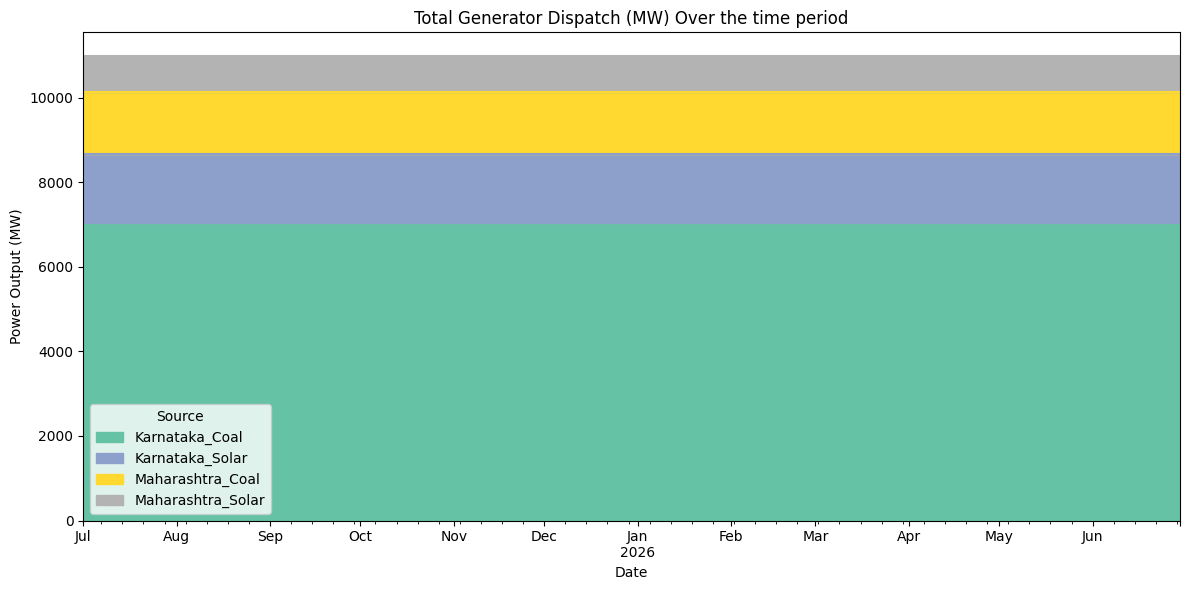

In [39]:
states_info = {
    "Karnataka": {"Solar": 9300, "Coal": 10000, "demand": 5000},
    "Maharashtra": {"Solar": 4800, "Coal": 15000, "demand": 6000}
}

n1 = simulate_dispatch(states_info, hours=24, apply_solar_tariff=False,yearly=True)
plot(n1)

### Analysis of yearly coal and solar power dispatch between Maharashtra and Karnataka without solar transmission subsidy

Index(['Karnataka Solar merge', 'Karnataka Coal merge',
       'Maharashtra Solar merge', 'Maharashtra Coal merge', 'Ka-Ma solar link',
       'Ka-Ma coal link'],
      dtype='object', name='Link')
Index(['Karnataka', 'Karnataka Solar Bus', 'Karnataka Coal Bus', 'Maharashtra',
       'Maharashtra Solar Bus', 'Maharashtra Coal Bus'],
      dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.05s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 3650 primals, 9490 duals
Objective: 8.97e+09
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.
C:\Users\Swapnil Paranjape\AppData\Local\Temp\ipykernel_6448\3780353702.py:10: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...


=== Generator Dispatch (First 5 Hours) ===
Generator   Karnataka Solar  Karnataka Coal  Maharashtra Solar  \
snapshot                                                         
2025-07-01           1674.0          3326.0              864.0   
2025-07-02           1674.0          3326.0              864.0   
2025-07-03           1674.0          3326.0              864.0   
2025-07-04           1674.0          3326.0              864.0   
2025-07-05           1674.0          3326.0              864.0   

Generator   Maharashtra Coal  
snapshot                      
2025-07-01            5136.0  
2025-07-02            5136.0  
2025-07-03            5136.0  
2025-07-04            5136.0  
2025-07-05            5136.0  

=== Transmission Flows (First 5 Hours) ===
Ka-Ma solar link
Ka-Ma coal link
Link        Ka-Ma solar link  Ka-Ma coal link
snapshot                                     
2025-07-01           -2000.0           2000.0
2025-07-02           -2000.0           2000.0
2025-07-03     

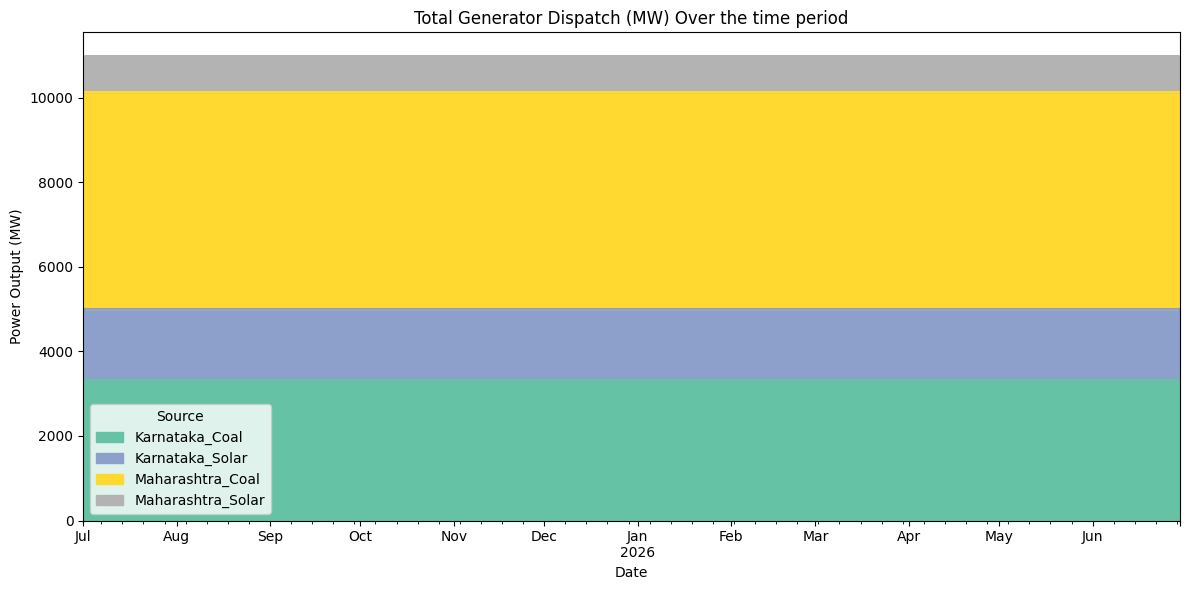

In [41]:
states_info = {
    "Karnataka": {"Solar": 9300, "Coal": 10000, "demand": 5000},
    "Maharashtra": {"Solar": 4800, "Coal": 15000, "demand": 6000}
}

n2 = simulate_dispatch(states_info, hours=24, apply_solar_tariff=True,yearly=True)
plot(n2)